# Notebook made by  

__Name(s)__: Afra Baas & Stijn Hamerslag & Isa-Ali Kirca & Juno Prent

__Student id(s)__ : 12417505 & 1323795 & 12014672 & 11915307


__This notebook has been made to plot the results with the metric which is the most comparable to the plot of the authors (last accuracy/parity/bias). Please keep in mind that:__

> This is only applicable if the provided datasets are used (german, compas and drug).

> Plots can onle be made if all the datasets together with all their attacks have been run with epsilons from 0.0 up to 1, otherwise it will most likely throw errors.

In [1]:
import glob
import csv
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
methods = ["/IAF-", "/RAA-", "/NRAA-"]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

In [3]:
# seed still needs to be implemented
def get_test_dicts(dataset, data_choice, methods, folder_measure, measure):
    # make the dicts
    last_dict = {"IAF":dict(), "RAA":dict(), "NRAA":dict()}
    
    # find all the files for the dataset
    for file_name in glob.glob("{}/{}/{}/*".format(data_choice, dataset, folder_measure)):
        for method in methods:
            if method in file_name:
                # strip the methods (/IAF-) etc. 
                meth = method[1:-1]
                splits = file_name.split("_")
                # find the epsilon in the filename 
                epsilon = [i for i in splits if "eps" in i][0].split("eps-")[1]
                data = pd.read_csv(file_name)
                # if there are nans in the data, skip them
                measured = data[~data[measure].isna()][measure]
                
                if measure == "test_acc":
                    # calculate test error
                    last_dict[meth][epsilon] = 1 - measured[measured.index[-1]]
                    
                else:
                    last_dict[meth][epsilon] = measured[measured.index[-1]] 

    return last_dict 


# same holds for this function, but this time we save the iterations and time taken
# which you have to run once for the time and one for the iterations
def get_time_and_it_dicts(dataset, data_choice, methods, time_and_it_folder, t_i_col):
    dict_ = {"IAF":dict(), "RAA":dict(), "NRAA":dict()}
    
    for file_name in glob.glob("{}/{}/{}/*".format(data_choice, dataset, time_and_it_folder)):
        for method in methods:
            if method in file_name:
                meth = method[1:-1]
                splits = file_name.split("_")
                epsilon = [i for i in splits if "eps" in i][0].split("eps-")[1]
                data = pd.read_csv(file_name)
                measured = data[~data[t_i_col].isna()][t_i_col]
                
                dict_[meth][epsilon] = measured[measured.index[-1]]
    return dict_

In [4]:
def plot_seed(datasets, data_choice, methods, folder_measure, measure, time_and_it, t_i_col):    
    # ta = test accuracy
    german_last_ta_dict = get_test_dicts(datasets[0], data_choice, methods, folder_measure[0], measures[0])
    compas_last_ta_dict = get_test_dicts(datasets[1], data_choice, methods, folder_measure[0], measures[0])
    drug_last_ta_dict = get_test_dicts(datasets[2], data_choice, methods, folder_measure[0], measures[0])
    
    
    # concat all three dicts into one df
    acc_df = pd.concat({'German acc': pd.DataFrame(german_last_ta_dict), 
                        'COMPAS acc': pd.DataFrame(compas_last_ta_dict), 
                        'Drug consumption acc': pd.DataFrame(drug_last_ta_dict)}).unstack(0).sort_index(axis = 0)
    

    # p = parity
    german_last_p_dict = get_test_dicts(datasets[0], data_choice, methods, folder_measure[1], measure[1])
    compas_last_p_dict = get_test_dicts(datasets[1], data_choice, methods, folder_measure[1], measure[1])
    drug_last_p_dict = get_test_dicts(datasets[2], data_choice, methods, folder_measure[1], measure[1])
    
    # concat all three dicts into one df
    p_df = pd.concat({'German par': pd.DataFrame(german_last_p_dict), 
                      'COMPAS par': pd.DataFrame(compas_last_p_dict), 
                      'Drug consumption par': pd.DataFrame(drug_last_p_dict)}).unstack(0).sort_index(axis = 0)

    # b = biases
    german_last_b_dict = get_test_dicts(datasets[0], data_choice, methods, folder_measure[1], measure[2])
    compas_last_b_dict = get_test_dicts(datasets[1], data_choice, methods, folder_measure[1], measure[2])
    drug_last_b_dict = get_test_dicts(datasets[2], data_choice, methods, folder_measure[1], measure[2])
    
    # concat all three dicts into one df
    b_df = pd.concat({'German bias': pd.DataFrame(german_last_b_dict), 
                      'COMPAS bias': pd.DataFrame(compas_last_b_dict), 
                      'Drug consumption bias': pd.DataFrame(drug_last_b_dict)}).unstack(0).sort_index(axis = 0)
    
    # to be able to make a plot loop
    dfs = [acc_df, p_df, b_df]
    
    ylabels = ["Test error", "Statistical parity", "Equality of opportunity"]
    lines = ['b-s', 'g-^', 'r-D']
    fig, axs = plt.subplots(3,3, figsize=(15, 10))
    axs = axs.ravel()
    
    fig.suptitle("{}".format(data_choice), fontsize=20, fontweight='heavy')
    
    for i in range(9):
        a = 0
        for j in range(0,9,3):
            t = i % 3
            
            # makes sure everything works as it has to
            if i <= 2:
                j += 0
            elif i > 2 and i <= 5:
                j += 1  
            elif i > 5:
                j += 2
                
            col = dfs[t].columns[j]
            column_data = dfs[t][col]

            axs[i].plot(column_data, lines[a], label="{}".format(column_data.name[0]))
            axs[i].set_title("{}".format(column_data.name[1].split(" ")[0]), fontweight='bold')
            axs[i].set_xlabel('Epsilon', fontweight='heavy')
            
            if "acc" in column_data.name[1]:
                axs[i].set_ylabel(ylabels[0], fontweight='heavy')
            elif "par" in column_data.name[1]:
                axs[i].set_ylabel(ylabels[1], fontweight='heavy')
            else:
                axs[i].set_ylabel(ylabels[2], fontweight='heavy')
            
            axs[i].legend(loc=9, ncol=3)
            axs[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4]) 
            axs[i].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1, "", ""])
    
            a += 1
        
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.6)
    plt.show()
    
    # show time taken and number of iterations in a dataframe
    time_taken_g = pd.DataFrame(get_time_and_it_dicts(datasets[0], 
                                data_choice, methods, time_and_it, t_i_col[0])).sort_index(axis=0)
    time_taken_c = pd.DataFrame(get_time_and_it_dicts(datasets[1], 
                                data_choice, methods, time_and_it, t_i_col[0])).sort_index(axis=0)
    time_taken_d = pd.DataFrame(get_time_and_it_dicts(datasets[2], 
                                         data_choice, methods, time_and_it, t_i_col[0])).sort_index(axis=0)
    
    
    last_iter_g = pd.DataFrame(get_time_and_it_dicts(datasets[0], data_choice, 
                                                     methods, time_and_it, t_i_col[1])).sort_index(axis=0)
    last_iter_c = pd.DataFrame(get_time_and_it_dicts(datasets[1], data_choice, 
                                                     methods, time_and_it, t_i_col[1])).sort_index(axis=0)
    last_iter_d = pd.DataFrame(get_time_and_it_dicts(datasets[2], data_choice, 
                                                     methods, time_and_it, t_i_col[1])).sort_index(axis=0)
    
    german_df = pd.concat({"Time (s)":time_taken_g, "# iters":last_iter_g}).unstack(0)
    compas_df = pd.concat({"Time (s)":time_taken_c, "# iters":last_iter_c}).unstack(0)
    drug_df = pd.concat({"Time (s)":time_taken_d, "# iters":last_iter_d}).unstack(0)
    german_df.index.name = "Epsilon"
    compas_df.index.name = "Epsilon"
    compas_df.index.name = "Epsilon"
    
    display(pd.concat({"German":german_df, "COMPAS":compas_df, "Drug consumption":drug_df}))

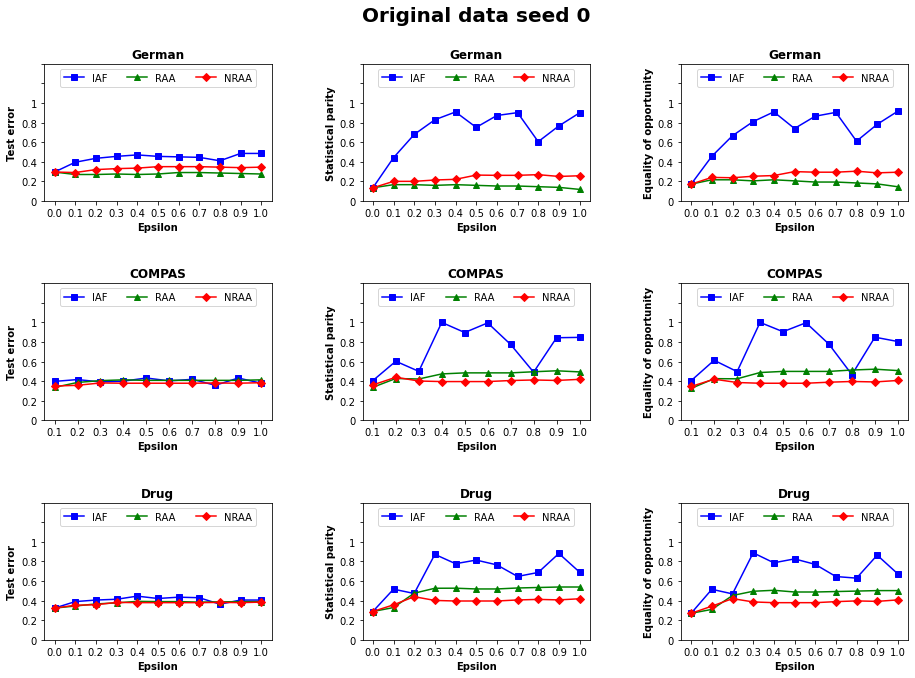

IAF                RAA                NRAA  \
                            Time (s) # iters   Time (s) # iters    Time (s)   
                 Epsilon                                                      
German           0.1      384.480745   188.0  32.436608    28.0   70.442690   
                 0.2      198.486952   128.0  31.562718    28.0   80.121993   
                 0.3      188.293482   128.0  34.446220    28.0   73.604044   
                 0.4      196.922482   138.0  37.891856    28.0   69.772674   
                 0.5      263.233532   198.0  35.111090    28.0   76.242508   
                 0.6      249.020238   188.0  28.125431    28.0   68.196489   
                 0.7      294.917908   218.0  28.901392    28.0   78.999868   
                 0.8      250.562111   188.0  29.160436    28.0   81.926721   
                 0.9      248.015013   178.0  33.580093    28.0   79.065947   
                 1.0      296.085860   208.0  40.428958    28.0   82.142464   
COMPAS           0.1      107.960184   128.0  19.470866    28.0  185.828425   
                 0.2       60.384706    68.0  23.606747    28.0  187.555029   
                 0.3       48.800643    48.0  23.051152    28.0  188.508828   
                 0.4       43.162889    48.0  22.389962    28.0  187.596503   
                 0.5       81.646531    88.0  22.633406    28.0  196.738306   
                 0.6       48.081563    48.0  26.779582    28.0  189.527463   
                 0.7       67.560022    68.0  22.357902    28.0  191.303064   
                 0.8       31.044235    28.0  24.124329    28.0  192.571382   
                 0.9       60.145187    58.0  23.826273    28.0  191.480495   
                 1.0       40.179632    38.0  28.038528    28.0  197.374235   
Drug consumption 0.1       69.464506   108.0  16.853679    38.0  167.816803   
                 0.2       68.885309    98.0  13.447741    28.0  170.423374   
                 0.3       36.891650    48.0  14.708600    28.0  168.435981   
                 0.4       58.317696    78.0  18.733285    28.0  169.575565   
                 0.5       34.053620    38.0  16.313574    28.0  172.990744   
                 0.6       54.852566    68.0  20.927060    28.0  170.977626   
                 0.7       26.012326    28.0  21.673026    28.0  181.106161   
                 0.8       25.109303    28.0  19.746233    28.0  178.028046   
                 0.9       26.292499    28.0  22.296534    28.0  169.088142   
                 1.0       33.263306    38.0  24.310237    28.0  177.082285   

                                  
                         # iters  
                 Epsilon          
German           0.1        28.0  
                 0.2        28.0  
                 0.3        28.0  
                 0.4        28.0  
                 0.5        28.0  
                 0.6        28.0  
                 0.7        28.0  
                 0.8        28.0  
                 0.9        28.0  
                 1.0        28.0  
COMPAS           0.1        28.0  
                 0.2        28.0  
                 0.3        28.0  
                 0.4        28.0  
                 0.5        28.0  
                 0.6        28.0  
                 0.7        28.0  
                 0.8        28.0  
                 0.9        28.0  
                 1.0        28.0  
Drug consumption 0.1        28.0  
                 0.2        28.0  
                 0.3        28.0  
                 0.4        28.0  
                 0.5        28.0  
                 0.6        28.0  
                 0.7        28.0  
                 0.8        28.0  
                 0.9        28.0  
                 1.0        28.0

In [13]:
methods = ["/IAF-", "/RAA-", "/NRAA-"]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
datasets = ["german", "compas", "drug"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

plot_seed(datasets, "Original data seed 0", methods, folder_measures, measures, 
          time_and_it, time_and_it_columns)

Make sure you **change the data_choice** (original data or authors data). So only the second parameter of plot_seed. The model automatically saves the data choice as:

    - dataset_choice: x seed y
    
with:

**x**: $\left\{\begin{array}{l}\text{Original data} \;\;\;\;\;\; \text { if  x == --original_data y} \;\; \text{OR} \;\; \text{x == --original_data yes} \\ \text{Authors data} \;\;\;\;\;\; \text { otherwise }\end{array}\right.$

**y**: $\left\{\begin{array}{l}y \in \{1,2,3\} \;\;\;\;\;\; \text { if  y == --rand_seed 1} \;\; \text{OR} \;\; \text{y == --rand_seed 2} \;\; \text{OR} \;\; \text{y == --rand_seed 3} \\ \text{0} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \text { otherwise }\end{array}\right.$

In [110]:
methods = ["/IAF-", "/RAA-", "/NRAA-"]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
datasets = ["german", "compas", "drug"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

In [104]:
# Make sure to change the second parameter (the seed and Authors/Original)

# plot_seed(datasets, "Authors data seed 0", methods, folder_measures, measures, 
#           time_and_it, time_and_it_columns)